In [63]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt

# Latex points to inches conversion factor
PTS_PER_INCH = 72.26999
# Latex text width in points
TEXT_WIDTH_PTS = 505.12177
# Latex column width in points
COLUMN_WIDTH_PTS = TEXT_WIDTH_PTS / 2
# Latex column width in inches
COLUMN_WIDTH_INCHES = COLUMN_WIDTH_PTS / PTS_PER_INCH
# Latex text width in inches
TEXT_WIDTH_INCHES = TEXT_WIDTH_PTS / PTS_PER_INCH
# DPI for figures
DPI = 600
# Font scale for figures
FONT_SCALE = 0.5

plt.rcParams['font.stretch'] = 'condensed'
plt.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('xtick', labelsize=5) 
matplotlib.rc('ytick', labelsize=5) 

def plot_signal(ds: xr.Dataset, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(ds['time'], ds['data'])
    ax.set_ylabel(f"{ds.attrs['units']}")
    ax.set_title(f'{ds.label}\n{ds.attrs["name"]}', fontsize=5)

def standardise_names(ds: xr.Dataset) -> xr.Dataset:
    for name in ['t', 'time1']:
        if name in ds:
            print(ds.attrs['name'])
            ds = ds.rename({name: 'time'})
    if 'time' not in ds:
        print(ds)
    return ds

In [70]:
data_path = Path('~/data/tiny').expanduser()
shot_files = list(data_path.glob('*.zarr'))
shot_file = data_path / '30420.zarr'

defuse_signals = [
    'ama/n=odd_amplitude',
    'ama/n=2_frequency',
    'amc/plasma_current',
    'asm/out_nn_rating',
    'esm/surface_area',
    'efm/bvac_rmag',
    'efm/triang_lower',
    'efm/triang_upper',
    'efm/plasma_currx',
    'efm/elongation',
    'efm/li',
    'efm/q_95',
    'efm/magnetic_axis_r',
    'efm/geom_axis_rc',
    'efm/plasma_volume',
    'efm/plasma_energy',
    'efm/current_centrd_z',
    'efm/magnetic_axis_z',
    'efm/minor_radius',
    'efm/lcfsr_c',
    'efm/lcfsz_c',
    'esm/v_loop_dynamic',
    'esm/v_loop_static',
    'xdc/ip_t_ipref',
    'xsx/hcam_l_1',
    'xsx/hcam_l_10',
    'xsx/hcam_l_11',
    'xsx/hcam_l_12',
    'xsx/hcam_l_13',
    'xsx/hcam_l_14',
    'xsx/hcam_l_15',
    'xsx/hcam_l_16',
    'xsx/hcam_l_17',
    'xsx/hcam_l_18',
    'xsx/hcam_l_2',
    'xsx/hcam_l_3',
    'xsx/hcam_l_4',
    'xsx/hcam_l_5',
    'xsx/hcam_l_6',
    'xsx/hcam_l_7',
    'xsx/hcam_l_8',
    'xsx/hcam_l_9',
    'xsx/hcam_u_1',
    'xsx/hcam_u_10',
    'xsx/hcam_u_11',
    'xsx/hcam_u_12',
    'xsx/hcam_u_13',
    'xsx/hcam_u_14',
    'xsx/hcam_u_15',
    'xsx/hcam_u_16',
    'xsx/hcam_u_17',
    'xsx/hcam_u_18',
    'xsx/hcam_u_2',
    'xsx/hcam_u_3',
    'xsx/hcam_u_4',
    'xsx/hcam_u_5',
    'xsx/hcam_u_6',
    'xsx/hcam_u_7',
    'xsx/hcam_u_8',
    'xsx/hcam_u_9',
    'xsx/tcam_1',
    'xsx/tcam_10',
    'xsx/tcam_11',
    'xsx/tcam_12',
    'xsx/tcam_13',
    'xsx/tcam_14',
    'xsx/tcam_15',
    'xsx/tcam_16',
    'xsx/tcam_17',
    'xsx/tcam_18',
    'xsx/tcam_2',
    'xsx/tcam_3',
    'xsx/tcam_4',
    'xsx/tcam_5',
    'xsx/tcam_6',
    'xsx/tcam_7',
    'xsx/tcam_8',
    'xsx/tcam_9',
]

datasets = {name:  xr.open_dataset(shot_file, group=name) for name in defuse_signals}
datasets = {name: standardise_names(ds) for name, ds in datasets.items()}
# Rescale plasma current
datasets['amc/plasma_current']['data'] * 1000
datasets['amc/plasma_current'].attrs['units'] = 'A'
# Rescale ipref 
datasets['xdc/ip_t_ipref']['data'] * 1000 * 1000
datasets['xdc/ip_t_ipref'].attrs['units'] = 'A'

/XDC/IP/T/IPREF


In [66]:
len(datasets)

24

In [72]:
fig, axes = plt.subplots(8, 3, figsize=(TEXT_WIDTH_INCHES, TEXT_WIDTH_INCHES))
for name, ax in zip(defuse_signals, axes.flatten()):
    plot_signal(datasets[name], ax=ax)

plt.tight_layout()

Error in callback <function flush_figures at 0x7f7e29cdbb00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [96]:
def add_camera_parameters(datasets: dict[str, xr.Dataset], path: str):
    cam_data = pd.read_csv(path)
    cam_data['comment'] = cam_data.comment.fillna('')
    cam_data = cam_data.set_index('name')
    for name, row in cam_data.iterrows():
        params = row.to_dict()
        datasets[name].attrs['camera_params'] = params

add_camera_parameters(datasets, 'xsx_camera_l.csv')
add_camera_parameters(datasets, 'xsx_camera_u.csv')
add_camera_parameters(datasets, 'xsx_camera_t.csv')

In [98]:
import zarr
file_name = '30420.zarr'
for key, dataset in datasets.items():
    dataset.to_zarr(file_name, group=key, mode='w')

zarr.consolidate_metadata(file_name)

from convert import main
main(file_name)

## Camera Data

In [16]:
df = pd.read_csv('xsx_camera_t.csv')
df

,name,r1,z1,r2,z2,p_mm,theta_rad,comment
0,XSX TCAM#1,1763.0,1441.0,0.0,0.00,0.0,0.000,Extreme inner channel (central column).
1,XSX TCAM#2,1763.0,1441.0,0.0,86.49,68.6,2.226,NaN
2,XSX TCAM#3,1763.0,1441.0,0.0,171.60,139.3,2.195,NaN
3,XSX TCAM#4,1763.0,1441.0,0.0,256.04,212.5,2.163,NaN
4,XSX TCAM#5,1763.0,1441.0,0.0,339.81,288.2,2.129,NaN
5,XSX TCAM#6,1763.0,1441.0,0.0,422.93,366.3,2.094,NaN
6,XSX TCAM#7,1763.0,1441.0,0.0,505.41,446.4,2.059,NaN
7,XSX TCAM#8,1763.0,1441.0,0.0,587.24,528.5,2.022,NaN
8,XSX TCAM#9,1763.0,1441.0,0.0,668.46,612.3,1.984,NaN
9,XSX TCAM#10,1763.0,1441.0,0.0,760.39,709.4,1.940,NaN


In [17]:
df['r1'].values

array([1763., 1763., 1763., 1763., 1763., 1763., 1763., 1763., 1763.,
       1763., 1763., 1763., 1763., 1763., 1763., 1763., 1763., 1763.])

In [18]:
df['r2'].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [19]:
df['z1'].values

array([1441., 1441., 1441., 1441., 1441., 1441., 1441., 1441., 1441.,
       1441., 1441., 1441., 1441., 1441., 1441., 1441., 1441., 1441.])

In [20]:
df['z2'].values

array([   0.  ,   86.49,  171.6 ,  256.04,  339.81,  422.93,  505.41,
        587.24,  668.46,  760.39,  840.27,  919.54,  998.21, 1076.28,
       1153.77, 1230.68, 1308.94, 1382.77])

## Plotting LCFS

998877000.0


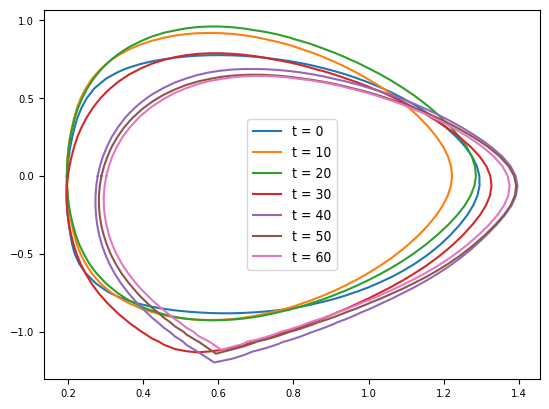

In [89]:
ds_z = xr.open_dataset('~/data/tiny/30390.zarr', group='efm/lcfsz_c', engine='zarr')
ds_r = xr.open_dataset('~/data/tiny/30390.zarr', group='efm/lcfsr_c', engine='zarr')

z = ds_z['data'].values
r = ds_r['data'].values

fill_value = np.max(z)
print(fill_value)

coords = {'r': [], 'z':[]}
for t in range(len(z)):
    coords['r'].append(r[t, r[t] < fill_value])
    coords['z'].append(z[t, z[t] < fill_value])

for t in range(0, len(z), 10):
    plt.plot(coords['r'][t], coords['z'][t], label=f't = {t}')

plt.legend()

### Magnetic Field Measurements: Center column vertical Bv array (CCBV), Outboard discrete B-field coils (OBV/OBR), Flux loops (FL)

In [106]:
import zarr

f = zarr.open_consolidated('/home/sljack/data/tiny/30420.zarr')
f = f['amb']
ds = {key: xr.open_dataset('~/data/tiny/30390.zarr', group=f'amb/{key}', engine='zarr') for key in f.keys() if 'ccbv' in key}

ds = xr.concat(ds, dim='n')
ds
# for k, v in ds.items():
#     plt.plot(v.time, v.data)

TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'str'>

## What is in XRT?

In [6]:
import datatree
ds = datatree.open_datatree('/home/sljack/data/tiny/30420.zarr/xrt', engine='zarr')
ds

DataTree('None', parent=None)
├── DataTree('cii_hu10_u')
│       Dimensions:  (sec: 7000)
│       Coordinates:
│         * sec      (sec) float32 28kB -0.09999 -0.09989 -0.09979 ... 0.5998 0.5999
│       Data variables:
│           data     (sec) float32 28kB ...
│           error    (sec) float32 28kB ...
│       Attributes: (12/17)
│           dataset_item_uuid:  9721478c-d1fc-5577-9524-b926060b79c3
│           description:        
│           file_name:          None
│           format:             None
│           label:              Volt
│           mds_name:           \TOP.RAW.XRT:CII_HU10_U
│           ...                 ...
│           shot_id:            30420
│           source:             XRT
│           status:             1
│           time_index:         0
│           type:               Raw
│           units:              V
├── DataTree('co2')
│       Dimensions:  (sec: 7000)
│       Coordinates:
│         * sec      (sec) float32 28kB -0.1 -0.0999 -0.0998 ... 0.5997 0.5998 0.5999
│       Data variables:
│           data     (sec) float32 28kB ...
│           error    (sec) float32 28kB ...
│       Attributes: (12/17)
│           dataset_item_uuid:  9c2c51b1-9b9c-551e-8215-6dfe5dddff85
│           description:        
│           file_name:          None
│           format:             None
│           label:              Volt
│           mds_name:           \TOP.RAW.XRT:CO2
│           ...                 ...
│           shot_id:            30420
│           source:             XRT
│           status:             1
│           time_index:         0
│           type:               Raw
│           units:              V
├── DataTree('da_bo10')
│       Dimensions:  (sec: 7000)
│       Coordinates:
│         * sec      (sec) float32 28kB -0.09999 -0.09989 -0.09979 ... 0.5998 0.5999
│       Data variables:
│           data     (sec) float32 28kB ...
│           error    (sec) float32 28kB ...
│       Attributes: (12/17)
│           dataset_item_uuid:  f4affb61-e0ab-54af-9f00-4692a8c2f2b2
│           description:        
│           file_name:          None
│           format:             None
│           label:              Volt
│           mds_name:           \TOP.RAW.XRT:DA_BO10
│           ...                 ...
│           shot_id:            30420
│           source:             XRT
│           status:             1
│           time_index:         0
│           type:               Raw
│           units:              V
├── DataTree('hcamu#2')
│       Dimensions:  (sec: 7000)
│       Coordinates:
│         * sec      (sec) float32 28kB -0.09998 -0.09988 -0.09978 ... 0.5998 0.5999
│       Data variables:
│           data     (sec) float32 28kB ...
│           error    (sec) float32 28kB ...
│       Attributes: (12/17)
│           dataset_item_uuid:  42785c73-7eb7-53e0-846e-0f3ada8fa6a1
│           description:        
│           file_name:          None
│           format:             None
│           label:              Volt
│           mds_name:           \TOP.RAW.XRT:HCAMU_2
│           ...                 ...
│           shot_id:            30420
│           source:             XRT
│           status:             1
│           time_index:         0
│           type:               Raw
│           units:              V
├── DataTree('hene')
│       Dimensions:  (sec: 7000)
│       Coordinates:
│         * sec      (sec) float32 28kB -0.1 -0.0999 -0.09979 ... 0.5997 0.5998 0.5999
│       Data variables:
│           data     (sec) float32 28kB ...
│           error    (sec) float32 28kB ...
│       Attributes: (12/17)
│           dataset_item_uuid:  81776493-eda3-5a4a-9107-cadd5451e693
│           description:        
│           file_name:          None
│           format:             None
│           label:              Volt
│           mds_name:           \TOP.RAW.XRT:HENE
│           ...                 ...
│           shot_id:            30420
│           source:             XRT
│           status:         

S3 File Cache

In [8]:
import s3fs
endpoint_url = f"https://s3.echo.stfc.ac.uk"
fs = s3fs.S3FileSystem(anon=True, endpoint_url=endpoint_url)
url = 's3://mast/test/shots/tiny/30390.zarr'
ds = xr.open_dataset(fs.get_mapper(url), engine='zarr', group=f'rba')

In [14]:
import s3fs
import fsspec
endpoint_url = f"https://s3.echo.stfc.ac.uk"
# fs = fsspec.filesystem("filecache", target_protocol='s3', target_options={'anon': True},
#                        cache_storage='/tmp/files/')
url = 's3://mast/test/shots/tiny/30390.zarr'
of = fsspec.open("filecache::" + url,
                 )
ds = xr.open_dataset("filecache::" + url, engine='zarr', group=f'rba', storage_options={'s3': {'anon': True, 'endpoint_url': endpoint_url}, 'filecache': {'cache_storage':'/tmp/files'}})

ValueError: Starting with Zarr 2.11.0, stores must be subclasses of BaseStore, if your store exposes the MutableMapping interface wrap it in Zarr.storage.KVStore. Got <OpenFile 'mast/test/shots/tiny/30390.zarr'>